# **GENERATIVE ADVERSARIAL NETWORK**
Using handwritten dataset for training GAN.

* The Generator model will learn how to generate new plausible handwritten digits between 0 and 9.
* The Discriminator will try to distinguish between real images from MNIST and new images output by the generator model. 



## LOAD DATASET 
MNIST dataset : 70.000 28x28 grayscale image of handwritten single digits between 0 and 9. 

In [1]:
# Load mnist dataset
from keras.datasets.mnist import load_data

# Load dataset into train and test set.
(X_train, Y_train), (X_test, Y_test) = load_data()

# Train set : 60.000 image 28x28 pixels and its label
# Test set : 10.000 image 28x28 pixels and its label
# The shape of input train and test
print("Train : ", X_train.shape, Y_train.shape)
print("Test : ", X_test.shape, Y_test.shape)

Train :  (60000, 28, 28) (60000,)
Test :  (10000, 28, 28) (10000,)


Grayscale image : black : 0 value, white : 256 


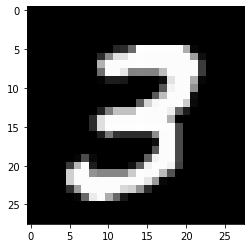

In [2]:
# Load example image
import matplotlib.pyplot as plt
plt.imshow(X_train[7], cmap='gray') # color map is 'gray' with grayscale image

# Load dataset with white background & black handwritten digits
#plt.imshow(X_train[7], cmap='gray_r')

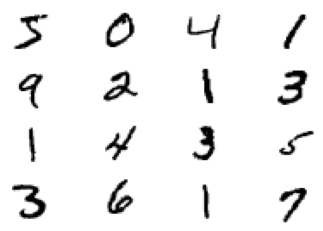

In [4]:
# Load first 16 images from the training dataset in a 4x4 square
for i in range(16):
  # define subplot
  plt.subplot(4, 4, i+1)
  # turn off the axis
  plt.axis('off')
  # Plot raw pixels data
  plt.imshow(X_train[i], cmap='gray_r')
plt.show()

## DEFINE DISCRIMINATOR MODEL

This is binary classification problem:
* **Inputs**: Image with one channel and 28x28 pixels in size
* **Outputs**: Binary Classification, likelihood the sample is real/fake

The discriminator model has 2 convolutional layers with:
* 64 filters each
* Small kernal size of 3
* Stride of 2
* No pooling layers 
* 1 single node output + sigmoid activation function 

The model is trained to minize the Binary cross entropy loss function (fit for Binary classification)

we will use some best practices in defining the discriminator model.
* LeakyReLU > ReLU (activation function)
* Dropout (Bỏ qua 1 số nút mạng tránh over-fitting)
* Adam version of stochastic gradient descent with learning rate 0.0002 and a momentum of 0.5 (Optimizers học từ input data, 1 cặp (weight, bias) để tối ưu hóa model)


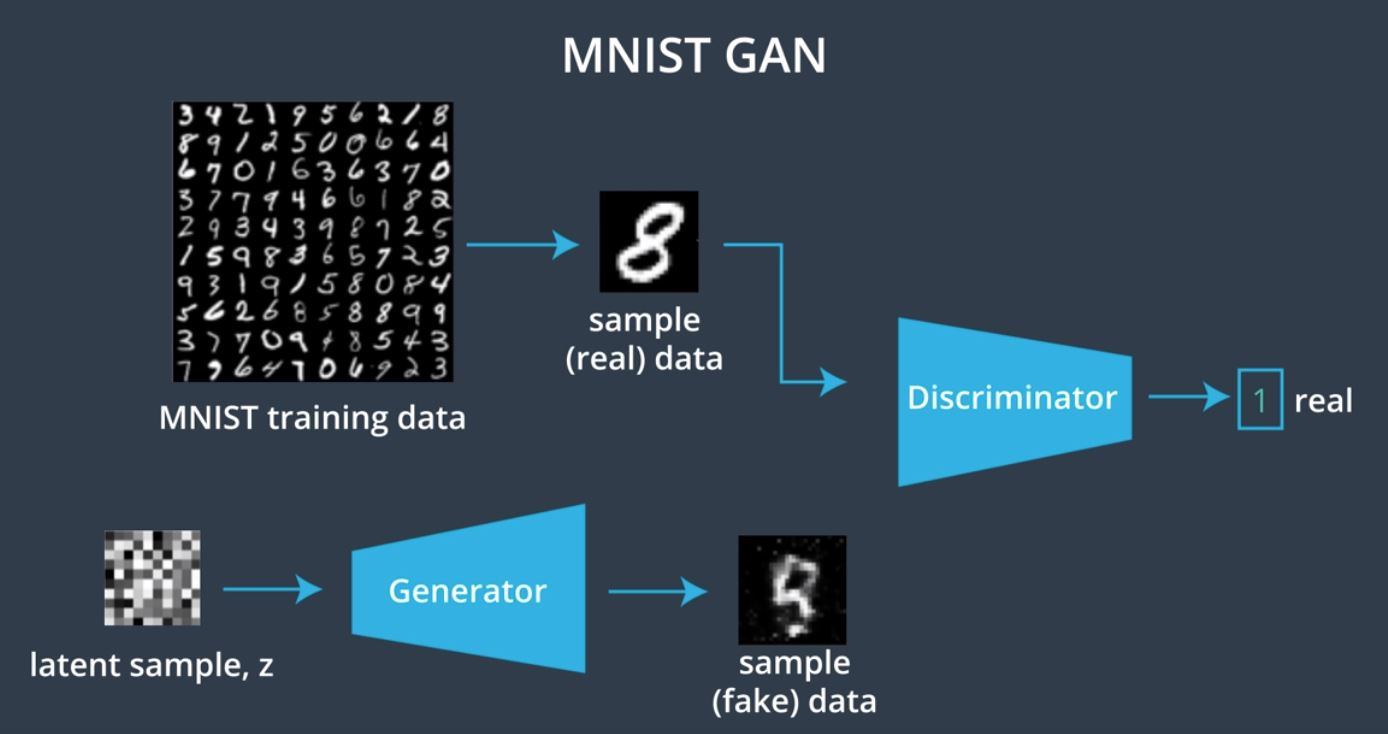



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


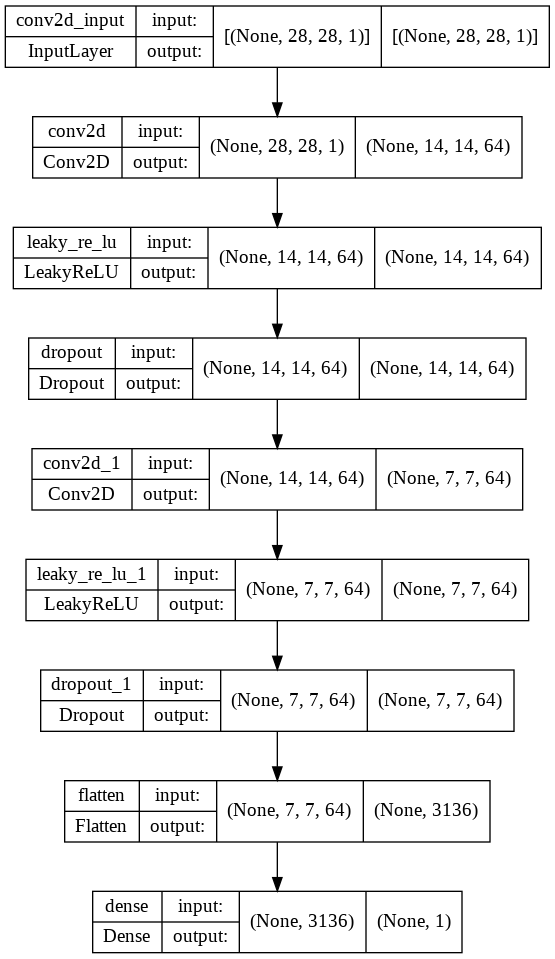

In [5]:
# Define_discriminator() define the discriminator model & parametrizes the size of the input image

from keras.models import Sequential # Thêm từng lớp vào mô hình theo cách tuyến tính, 1 input tensor & 1 output tensor. 
from keras.optimizers import adam_v2
from keras.layers import Dense # densely-connected NN layers (Lớp NN liên kết đầy đủ)
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model # Chuyển mô hình keras sang dot format và lưu vào file

def define_discriminator(in_shape=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
  # 64 bộ lọc
  # Stride : Bước trượt
  # Padding : số nguyên hoặc same: đầu ra có giá trị bằng với đầu vào
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  # Compile model
  opt = adam_v2.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

# Define model
model = define_discriminator()

# Sumarize model
model.summary()

#Plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)


**Load & Preapre real image**

The images are 2D arrays. CNN expects 3D arrays of images as input. 

=> We must update the iamges to have an additional dimension for grayscale channel. 

Using **expand_dims(X_train, axis=-1)**

In [6]:
# Load and Prepare mnist trainning images
import numpy as np
from numpy import expand_dims

def load_real_samples():
  # Load MNIST dataset
  (X_train,_), (_,_) = load_data()
  # Expand to 3D image (add channels dimension)
  X = np.expand_dims(X_train, axis=-1)
  # Scale the pixel values from [0,225] to [0,1]
  X = X.astype('float32')
  # Scale from [0,255] to [0,1]
  X = X/255.0
  return X

*  Model will be updated in batche (Model sẽ được cập nhật qua mỗi batches)

* On training, epoch is defined as one pass through the entire training dataset
 (Trong quá trình train, mỗi epoch được xem là một lần pass qua toàn bộ dữ liệu)
* Stochastic Gradient Descent requires train set be shuffled prior to each epoch. Simpler approach : select random samples from train set (SGD yêu cầu dữ liệu phải được xáo trộn trước mỗi epoch, cách đơn giản nhất là chọn random)

**generate_real_samples()** function will select a random subsample of images.
Return class labels 1 indicate real image (Hàm này sẽ chọn random 1 tập ảnh con và trả về tập ảnh đó và labels của nó)



In [7]:
# Select a real samples
from numpy.random import randint
from numpy import ones

def generate_real_samples(dataset, n_samples):
  # Choose random instances (Chọn các index ngẫu nhiên)
  ix = randint(0, dataset.shape[0], n_samples)

  # Retrieve selected images (Lấy những ảnh được chọn)
  X = dataset[ix]

  # Generate real class labels - 1
  y = ones((n_samples, 1))

  return X, y



So we create a generator function to generate random pixels values of image. Values in range [0,1] (same as real image)

* **generate_fake_samples()** generate images of random pixels values and class label 0 for fake.

In [8]:
# Generate n fake samples with class labels 
from numpy.random import rand
from numpy import zeros

def generate_fake_samples(n_samples):
  # generate uniform random numbers in [0,1]
  X = rand(28 * 28 * n_samples)         # Create a list of 28*28*n_samples numbers
  # Reshape into grayscale iamges
  X = X.reshape((n_samples, 28, 28, 1)) # Generate n_sample image, size 28*28, channela = 1 (grayscale images)
  # Generate 'fake' class labels - 0 
  y = zeros((n_samples, 1))
  
  return X, y

## TRAIN DISCRIMINATOR MODEL
* Repeat retrieving real/ fake images and updating the model for a fixed number of iterations *(Lặp lại việc truy vấn ảnh real & fake và cặp nhật lại số vòng lặp thích hợp)*


* Model will learn to discriminate between real and fake images rapidly, So not many batches will be required before it learns to discriminate perfectly *(Mô hình sẽ học cách phân biệt ảnh real & fake nhanh chóng mà không cần nhiều batches)*


* **train_discriminator()** có batch size = 256 ảnh gồm 128 ảnh real và 128 ảnh fake cho mỗi vòng lặp *(batch size of 256 images where 128 are real and 128 are fake each iteration)*


* We update the discriminator separately for real and fake examples to calculate accuracy on each sample prior to the update *(Chúng ta sẽ cập nhật riêng biệt discriminator cho ảnh real và fake để tính accuracy trước khi update mỗi ảnh)*


In [9]:
# Train discriminator model 
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
  half_batch = int(n_batch/2)
  # Manually enumerate epochs
  for i in range(n_iter):

    # Get randomly selected 'real' sample
    X_real, y_real = generate_real_samples(dataset, half_batch)

    # Update discriminator on real samples
    _, real_acc = model.train_on_batch(X_real, y_real)

    # Generate fake examples
    X_fake, y_fake = generate_fake_samples(half_batch)

    # Update discriminator on fake samples
    _, fake_acc = model.train_on_batch(X_fake, y_fake) 

    # Summarize performance
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

# define discriminator model
model = define_discriminator()

#load image data
dataset = load_real_samples()

# fit the model 
train_discriminator(model, dataset)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1 real=57% fake=55%
>2 real=64% fake=75%
>3 real=73% fake=80%
>4 real=68% fake=98%
>5 real=70% fake=98%
>6 real=69% fake=99%
>7 real=66% fake=99%
>8 real=78% fake=100%
>9 real=70% fake=100%
>10 real=70% fake=100%
>11 real=72% fake=100%
>12 real=78% fake=100%
>13 real=77% fake=100%
>14 real=75% fake=100%
>15 real=80% fake=100%
>16 real=86% fake=100%
>17 real=79% fake=100%
>18 real=86% fake=100%
>19 real=88% fake=100%
>20 real=87% fake=100%
>21 real=92% fake=100%
>22 real=91% fake=100%
>23 real=95% fake=100%
>24 real=96% fake=100%
>25 real=97% fake=100%
>26 real=95% fake=100%
>27 real=96% fake=100%
>28 real=98% fake=100%
>29 real=99% fake=100%
>30 real=100% fake=100%
>31 real=99% fake=100%
>32 real=99% fake=100%
>33 real=98% fake=100%
>34 real=100% fake=100%
>35 real=98% fake=100%
>36 real=99% fake=100%
>37 real=100% fake=100%
>38 real=100% fake=100%
>39 real=98% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=99% fake=100%
>44 real=100% fake=1

## DEFINE GENERATOR MODEL

Generater model will create new, fake but plausible images of HWD (sinh ra ảnh fake nhưng hợp lí như ảnh thật)

Taking a point from the latent space as input and outputting a square grayscale image (G.M lấy một điểm từ latent space và cho ra ảnh mức xám) 

Latent space : là một không không gian vector được xác định tùy ý của các giá trị được phân phối theo Gausian. Chúng không có ý nghĩa gì, nhưng bằng cách lấy 1 điểm ngẫu nhiên từ latent space này và truyền chúng vào GM trong quá trình training. GM sẽ gán ý nghĩa cho điểm, latent space. Đến cuối quá trình training, latent vector space đại diện cho một biểu diễn nén cho không gian đầu ra. Chỉ có GM mới có thể biến chúng thành ảnh MNIST hợp lí.
* **Input** : point in latent space, e.g. a 100 element vector of Gausian random number
* **Outputs** : 2-dimensional square grayscale image 28*28 pixels values in [0,1]

Developing a generator model requires that we transform a vector from the latent space with 100 dimensions to a 2D array with 28×28 or 784 values (GM chuyển vector 100 chiều trong latent space sang mảng 2 chiều 28*28 / 784 giá trị)

Two main element have effective at deep convolutional generative adversarial networks:
* Dense layer as the first hidden layer that has enough nodes to represent a low-resolution version of the output image (Lớp ẩn đầu tiên có đủ các node đại diện cho ảnh đầu vào có độ phân giải thấp)
* This is a pattern in CNN where we have many parallel filters resulting in multiple parallel activation maps, called feature maps, with different interpretations of the input. We want many parallel versions of our output with different learned features that can be collapsed in the output layer into a final image (Chúng ta cần nhiều phiên bản song song của ảnh đầu vào. Đây là pattern in CNN, trong đó có rất nhiều bộ lọc song song khác nhau, còn gọi là bản đồ đặc trưng khác nhau ở đầu vào. Ngược lại, chúng tôi muốn nhiều phiên bản đầu ra song song với các tính năng đã học và tạo ra hình ảnh cuối cùng) 

=> Dense (first hidden layer) needs enough nodes for multiple low-resolution versions of out images as 128 (lớp ẩn đầu tiên cần đủ số node cho nhiều phiên bản có độ phân giải thấp, vd như 128 node)


In [10]:
# foundation for 7x7 image
# model.add(Dense(128 * 7 * 7, input_dim=100)) 
# model.add(Reshape((7, 7, 128))) => 128 feature maps size 7x7

Next step, upsampling the low-resolution image to higher resolution (Bước tiếp theo, chuyển ảnh có độ phân giải thấp thành ảnh có độ phân giải cao)

Using Conv2DTranspose (reverse pooling layer + Conv2D layer), stride = (2,2) will x4 input feature maps (double width & height dims) 


In [11]:
# upsample to 14x14
# model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))

=> Repeat to arrive our 28x28 output image

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

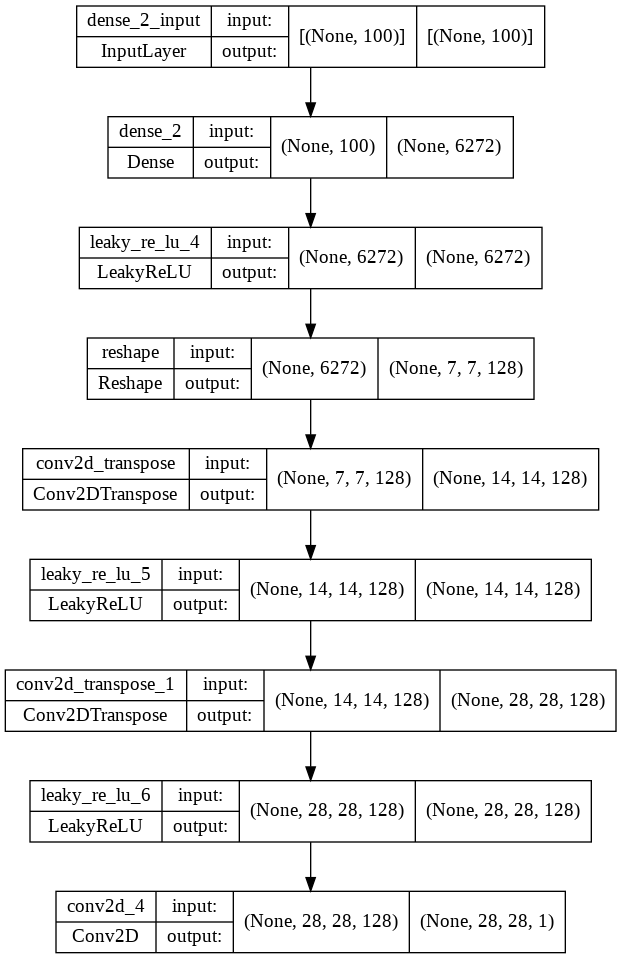

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# Define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()

  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7,7,128)))

  # Upsample to 14x14 
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Upsample to 28x28 
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation='sigmoid', padding ='same')) # Sigmoid activation ensure output in [0,1]
  return model

# Define size of latent space
latent_dim = 100

# Define generator model
model = define_generator(latent_dim)

# Summarize model
model.summary()

# Plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

First layer (Dense) has 6.272 param (128 * 7 * 7) => reshape into 128 7x7 feature maps

Feature map upscales via Conv2DTranspose layer to size 28x28 

Output layer : one activation map 

Model need 100 elements point from latent space as input, then generate output image


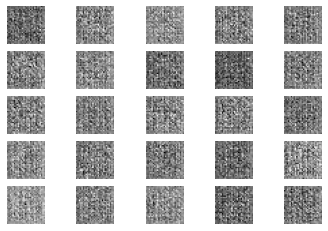

In [13]:
from numpy import zeros
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from matplotlib import pyplot
 
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()

## TRAIN GENERATOR MODEL
Weights in the generator model are updated based on the performance of the discriminator model (Trọng số trong generator được cập nhật thông qua hiệu xuất của discriminator)

* Khi discriminator detect ảnh tốt => Generator sẽ được update nhiều
* Khi discriminator detect ảnh tệ => Generator sẽ update ít

The GAN model is designed to stack generator and discriminator. Generator takes as input a random point in latent space and generates a fake image. Then pass this fake image through the discriminator to classify and update the parameters for the generator through backpropagation.

Mô hình GAN được thiết kế xếp chồng generator và discriminator. Generator nhận input là 1 điểm ngẫu nhiên trong latent space và tạo ra 1 ảnh fake. Sau đó truyền ảnh fake này qua discriminator để phân loại và cập nhật lại tham số cho cho generator qua quá tình lan truyền ngược.
* **Input** : Point in latent space, e.g. a 100 element vector of Gaussian random numbers.
* **Output** : Binary classification, likelihood the sample is real (or fake)


In [14]:
# Define the combines generator & discriminator model, for updating the generator 
def define_gan(g_model, d_model):

  # make wweights in the discriminator not trainable 
  d_model.trainable = False

  # Connect them
  model = Sequential()

  # Add generator 
  model.add(g_model)

  # Add discriminator 
  model.add(d_model)

  # Compile model
  opt = adam_v2.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 28, 28, 1)         1164289   


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                 
 sequential_4 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


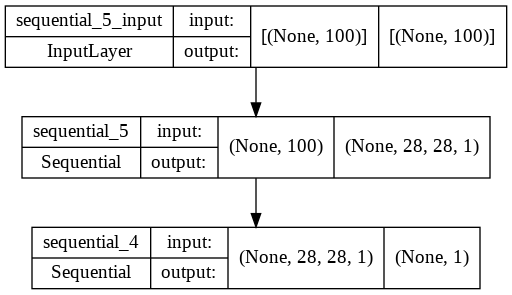

In [15]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):

	# manually enumerate epochs
	for i in range(n_epochs):
    # prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch) 
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))  
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

Need to update Discriminator with fake and real samples, then update generator. Cần update Discriminator với ảnh thật và giả sau đó update generator.

=> Cần sự kết hợp của train_discriminator() + train_gan(). Chúng yêu cầu tính số epochs và batches trong mỗi epochs

Trong train function, số batches trong mỗi epoch = 60k samples / 256 = 234 
batches 

Loss trong mỗi batch là giá trị loss mà generator sinh ra những mẫu rác mà discriminator dễ detect ra được




In [17]:
from numpy import vstack

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

## EVALUATE GAN MODEL PERFORMANCE 
Nhìn chung, chưa có cách khách quan nào để đánh giá hiệu xuất của mô hình GAN.

Chúng ta không thể tính độ lỗi của bước ảnh được sinh ra. Thay vào đó, ảnh sinh được đánh giá bởi con người. Điều đó có nghĩa là chúng ta không biết khi nào nên dừng quá trình training nếu không nhìn vào kết quả của những ảnh sinh. 

Ngược lại, bản chất đối nghịch của quá trình tạo có nghĩa là generator sẽ thay đổi sau mỗi batch. Nghĩa là khi một bức ảnh đủ "tốt" được sinh ra, chất lượng của ảnh sinh sau đó có thể trở nên tốt hơn nữa hoặc tệ đi qua những lần cập nhật tiếp theo của Generator. 

Có 3 cách xử lí tình huống phức tạp này trong lúc training:
* Đánh giá độ chính xác mức độ phân loại của Discriminator theo định kì 
* Tạo ra 1 tập các ảnh sinh, lưu vào file để xem một cách chủ quan theo định kỳ
* Lưu mô hình generator định kì

Cả 3 cách trên đều có thể được thực hiện cùng lúc trong một số lượng epoch nhất định như 5 hoặc 10 epoch. Mô hình trong mỗi số epoch sẽ được lại để chúng ta có thể đánh giá chất lượng ảnh sinh. Và mức độ Discriminator bị đánh lừa.

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

## GAN for MNIST

In [18]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import adam_v2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = adam_v2.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = adam_v2.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, 1/234, d=0.679, g=0.714
>1, 2/234, d=0.670, g=0.735
>1, 3/234, d=0.654, g=0.758
>1, 4/234, d=0.648, g=0.776
>1, 5/234, d=0.644, g=0.801
>1, 6/234, d=0.628, g=0.825
>1, 7/234, d=0.623, g=0.842
>1, 8/234, d=0.616, g=0.861
>1, 9/234, d=0.603, g=0.879
>1, 10/234, d=0.599, g=0.888
>1, 11/234, d=0.599, g=0.877
>1, 12/234, d=0.602, g=0.865
>1, 13/234, d=0.608, g=0.839
>1, 14/234, d=0.609, g=0.811
>1, 15/234, d=0.614, g=0.779
>1, 16/234, d=0.619, g=0.756
>1, 17/234, d=0.616, g=0.738
>1, 18/234, d=0.610, g=0.727
>1, 19/234, d=0.610, g=0.719
>1, 20/234, d=0.605, g=0.713
>1, 21/234, d=0.596, g=0.710
>1, 22/234, d=0.585, g=0.708
>1, 23/234, d=0.579, g=0.707
>1, 24/234, d=0.571, g=0.706
>1, 25/234, d=0.560, g=0.705
>1, 26/234, d=0.548, g=0.705
>1, 27/234, d=0.546, g=0.705
>1, 28/234, d=0.533, g=0.706
>1, 29/234, d=0.518, g=0.706
>1, 30/234, d=0.513, g=0.706
>1, 31/234, d=0.507, g=0.706
>1, 32/234, d=0.497, g=0.707
>1, 33/234, d=0.484, g=0.708
>1, 34/234, d=0.480, g=0.709
>1, 35/234, d=0.473, g=

>11, 1/234, d=0.673, g=0.698
>11, 2/234, d=0.680, g=0.683
>11, 3/234, d=0.684, g=0.687
>11, 4/234, d=0.681, g=0.693
>11, 5/234, d=0.670, g=0.702
>11, 6/234, d=0.682, g=0.716
>11, 7/234, d=0.677, g=0.729
>11, 8/234, d=0.685, g=0.755
>11, 9/234, d=0.670, g=0.763
>11, 10/234, d=0.676, g=0.735
>11, 11/234, d=0.677, g=0.721
>11, 12/234, d=0.681, g=0.707
>11, 13/234, d=0.676, g=0.690
>11, 14/234, d=0.679, g=0.675
>11, 15/234, d=0.680, g=0.675
>11, 16/234, d=0.681, g=0.676
>11, 17/234, d=0.693, g=0.689
>11, 18/234, d=0.691, g=0.687
>11, 19/234, d=0.689, g=0.705
>11, 20/234, d=0.698, g=0.706
>11, 21/234, d=0.688, g=0.727
>11, 22/234, d=0.693, g=0.730
>11, 23/234, d=0.689, g=0.739
>11, 24/234, d=0.694, g=0.728
>11, 25/234, d=0.687, g=0.714
>11, 26/234, d=0.685, g=0.700
>11, 27/234, d=0.683, g=0.687
>11, 28/234, d=0.692, g=0.693
>11, 29/234, d=0.686, g=0.690
>11, 30/234, d=0.689, g=0.694
>11, 31/234, d=0.689, g=0.705
>11, 32/234, d=0.687, g=0.706
>11, 33/234, d=0.689, g=0.717
>11, 34/234, d=0.68

>21, 1/234, d=0.681, g=0.659
>21, 2/234, d=0.685, g=0.668
>21, 3/234, d=0.701, g=0.699
>21, 4/234, d=0.681, g=0.732
>21, 5/234, d=0.692, g=0.737
>21, 6/234, d=0.697, g=0.710
>21, 7/234, d=0.687, g=0.690
>21, 8/234, d=0.689, g=0.689
>21, 9/234, d=0.694, g=0.696
>21, 10/234, d=0.687, g=0.699
>21, 11/234, d=0.687, g=0.713
>21, 12/234, d=0.706, g=0.729
>21, 13/234, d=0.686, g=0.736
>21, 14/234, d=0.685, g=0.736
>21, 15/234, d=0.687, g=0.729
>21, 16/234, d=0.692, g=0.697
>21, 17/234, d=0.691, g=0.669
>21, 18/234, d=0.685, g=0.666
>21, 19/234, d=0.692, g=0.685
>21, 20/234, d=0.684, g=0.717
>21, 21/234, d=0.687, g=0.713
>21, 22/234, d=0.689, g=0.725
>21, 23/234, d=0.687, g=0.706
>21, 24/234, d=0.687, g=0.701
>21, 25/234, d=0.694, g=0.684
>21, 26/234, d=0.681, g=0.696
>21, 27/234, d=0.694, g=0.727
>21, 28/234, d=0.688, g=0.733
>21, 29/234, d=0.692, g=0.722
>21, 30/234, d=0.684, g=0.710
>21, 31/234, d=0.688, g=0.697
>21, 32/234, d=0.684, g=0.693
>21, 33/234, d=0.692, g=0.699
>21, 34/234, d=0.68

>31, 1/234, d=0.692, g=0.667
>31, 2/234, d=0.684, g=0.678
>31, 3/234, d=0.692, g=0.712
>31, 4/234, d=0.685, g=0.729
>31, 5/234, d=0.691, g=0.730
>31, 6/234, d=0.690, g=0.693
>31, 7/234, d=0.682, g=0.704
>31, 8/234, d=0.688, g=0.701
>31, 9/234, d=0.689, g=0.700
>31, 10/234, d=0.682, g=0.709
>31, 11/234, d=0.687, g=0.714
>31, 12/234, d=0.685, g=0.701
>31, 13/234, d=0.691, g=0.688
>31, 14/234, d=0.693, g=0.707
>31, 15/234, d=0.681, g=0.743
>31, 16/234, d=0.696, g=0.737
>31, 17/234, d=0.691, g=0.731
>31, 18/234, d=0.689, g=0.701
>31, 19/234, d=0.698, g=0.678
>31, 20/234, d=0.680, g=0.699
>31, 21/234, d=0.696, g=0.724
>31, 22/234, d=0.686, g=0.711
>31, 23/234, d=0.684, g=0.698
>31, 24/234, d=0.686, g=0.696
>31, 25/234, d=0.685, g=0.694
>31, 26/234, d=0.688, g=0.694
>31, 27/234, d=0.685, g=0.725
>31, 28/234, d=0.688, g=0.734
>31, 29/234, d=0.685, g=0.711
>31, 30/234, d=0.690, g=0.693
>31, 31/234, d=0.690, g=0.724
>31, 32/234, d=0.682, g=0.732
>31, 33/234, d=0.685, g=0.730
>31, 34/234, d=0.68

>41, 1/234, d=0.685, g=0.735
>41, 2/234, d=0.686, g=0.703
>41, 3/234, d=0.690, g=0.688
>41, 4/234, d=0.688, g=0.707
>41, 5/234, d=0.696, g=0.718
>41, 6/234, d=0.689, g=0.709
>41, 7/234, d=0.680, g=0.685
>41, 8/234, d=0.691, g=0.671
>41, 9/234, d=0.690, g=0.682
>41, 10/234, d=0.679, g=0.697
>41, 11/234, d=0.696, g=0.741
>41, 12/234, d=0.685, g=0.762
>41, 13/234, d=0.681, g=0.727
>41, 14/234, d=0.693, g=0.693
>41, 15/234, d=0.687, g=0.681
>41, 16/234, d=0.700, g=0.690
>41, 17/234, d=0.692, g=0.701
>41, 18/234, d=0.684, g=0.721
>41, 19/234, d=0.689, g=0.748
>41, 20/234, d=0.686, g=0.754
>41, 21/234, d=0.685, g=0.713
>41, 22/234, d=0.685, g=0.688
>41, 23/234, d=0.688, g=0.672
>41, 24/234, d=0.685, g=0.670
>41, 25/234, d=0.683, g=0.719
>41, 26/234, d=0.688, g=0.769
>41, 27/234, d=0.681, g=0.766
>41, 28/234, d=0.678, g=0.748
>41, 29/234, d=0.690, g=0.715
>41, 30/234, d=0.690, g=0.683
>41, 31/234, d=0.678, g=0.690
>41, 32/234, d=0.678, g=0.687
>41, 33/234, d=0.685, g=0.707
>41, 34/234, d=0.69

>51, 1/234, d=0.684, g=0.732
>51, 2/234, d=0.687, g=0.705
>51, 3/234, d=0.695, g=0.727
>51, 4/234, d=0.693, g=0.715
>51, 5/234, d=0.687, g=0.691
>51, 6/234, d=0.684, g=0.697
>51, 7/234, d=0.694, g=0.694
>51, 8/234, d=0.694, g=0.699
>51, 9/234, d=0.684, g=0.697
>51, 10/234, d=0.691, g=0.694
>51, 11/234, d=0.683, g=0.682
>51, 12/234, d=0.683, g=0.704
>51, 13/234, d=0.682, g=0.722
>51, 14/234, d=0.691, g=0.724
>51, 15/234, d=0.689, g=0.699
>51, 16/234, d=0.691, g=0.679
>51, 17/234, d=0.684, g=0.685
>51, 18/234, d=0.691, g=0.706
>51, 19/234, d=0.690, g=0.731
>51, 20/234, d=0.692, g=0.739
>51, 21/234, d=0.690, g=0.728
>51, 22/234, d=0.689, g=0.697
>51, 23/234, d=0.681, g=0.666
>51, 24/234, d=0.671, g=0.694
>51, 25/234, d=0.691, g=0.696
>51, 26/234, d=0.691, g=0.723
>51, 27/234, d=0.692, g=0.719
>51, 28/234, d=0.686, g=0.699
>51, 29/234, d=0.691, g=0.697
>51, 30/234, d=0.693, g=0.698
>51, 31/234, d=0.685, g=0.716
>51, 32/234, d=0.687, g=0.709
>51, 33/234, d=0.679, g=0.701
>51, 34/234, d=0.68

>61, 1/234, d=0.686, g=0.691
>61, 2/234, d=0.684, g=0.663
>61, 3/234, d=0.686, g=0.657
>61, 4/234, d=0.693, g=0.686
>61, 5/234, d=0.701, g=0.730
>61, 6/234, d=0.695, g=0.779
>61, 7/234, d=0.690, g=0.747
>61, 8/234, d=0.694, g=0.702
>61, 9/234, d=0.683, g=0.674
>61, 10/234, d=0.695, g=0.648
>61, 11/234, d=0.691, g=0.684
>61, 12/234, d=0.694, g=0.735
>61, 13/234, d=0.683, g=0.751
>61, 14/234, d=0.694, g=0.745
>61, 15/234, d=0.695, g=0.713
>61, 16/234, d=0.691, g=0.674
>61, 17/234, d=0.696, g=0.678
>61, 18/234, d=0.697, g=0.708
>61, 19/234, d=0.688, g=0.733
>61, 20/234, d=0.693, g=0.707
>61, 21/234, d=0.681, g=0.682
>61, 22/234, d=0.681, g=0.688
>61, 23/234, d=0.698, g=0.704
>61, 24/234, d=0.682, g=0.730
>61, 25/234, d=0.688, g=0.722
>61, 26/234, d=0.684, g=0.699
>61, 27/234, d=0.693, g=0.671
>61, 28/234, d=0.692, g=0.683
>61, 29/234, d=0.685, g=0.717
>61, 30/234, d=0.694, g=0.743
>61, 31/234, d=0.700, g=0.704
>61, 32/234, d=0.689, g=0.706
>61, 33/234, d=0.691, g=0.686
>61, 34/234, d=0.69

>71, 1/234, d=0.691, g=0.712
>71, 2/234, d=0.692, g=0.726
>71, 3/234, d=0.686, g=0.733
>71, 4/234, d=0.689, g=0.697
>71, 5/234, d=0.692, g=0.685
>71, 6/234, d=0.690, g=0.698
>71, 7/234, d=0.698, g=0.715
>71, 8/234, d=0.682, g=0.713
>71, 9/234, d=0.694, g=0.699
>71, 10/234, d=0.689, g=0.703
>71, 11/234, d=0.694, g=0.704
>71, 12/234, d=0.696, g=0.727
>71, 13/234, d=0.692, g=0.706
>71, 14/234, d=0.697, g=0.693
>71, 15/234, d=0.691, g=0.678
>71, 16/234, d=0.690, g=0.688
>71, 17/234, d=0.693, g=0.723
>71, 18/234, d=0.683, g=0.729
>71, 19/234, d=0.688, g=0.721
>71, 20/234, d=0.693, g=0.717
>71, 21/234, d=0.693, g=0.711
>71, 22/234, d=0.685, g=0.681
>71, 23/234, d=0.691, g=0.679
>71, 24/234, d=0.692, g=0.695
>71, 25/234, d=0.677, g=0.726
>71, 26/234, d=0.689, g=0.698
>71, 27/234, d=0.695, g=0.704
>71, 28/234, d=0.688, g=0.699
>71, 29/234, d=0.694, g=0.722
>71, 30/234, d=0.695, g=0.741
>71, 31/234, d=0.688, g=0.718
>71, 32/234, d=0.695, g=0.702
>71, 33/234, d=0.691, g=0.676
>71, 34/234, d=0.68

>81, 1/234, d=0.694, g=0.746
>81, 2/234, d=0.702, g=0.707
>81, 3/234, d=0.683, g=0.682
>81, 4/234, d=0.696, g=0.681
>81, 5/234, d=0.685, g=0.683
>81, 6/234, d=0.693, g=0.687
>81, 7/234, d=0.694, g=0.704
>81, 8/234, d=0.697, g=0.711
>81, 9/234, d=0.689, g=0.721
>81, 10/234, d=0.688, g=0.702
>81, 11/234, d=0.695, g=0.711
>81, 12/234, d=0.688, g=0.697
>81, 13/234, d=0.698, g=0.689
>81, 14/234, d=0.688, g=0.736
>81, 15/234, d=0.688, g=0.733
>81, 16/234, d=0.691, g=0.712
>81, 17/234, d=0.695, g=0.679
>81, 18/234, d=0.689, g=0.683
>81, 19/234, d=0.691, g=0.687
>81, 20/234, d=0.698, g=0.708
>81, 21/234, d=0.686, g=0.700
>81, 22/234, d=0.693, g=0.692
>81, 23/234, d=0.687, g=0.695
>81, 24/234, d=0.692, g=0.735
>81, 25/234, d=0.697, g=0.732
>81, 26/234, d=0.686, g=0.714
>81, 27/234, d=0.688, g=0.689
>81, 28/234, d=0.688, g=0.696
>81, 29/234, d=0.703, g=0.695
>81, 30/234, d=0.696, g=0.701
>81, 31/234, d=0.699, g=0.682
>81, 32/234, d=0.694, g=0.686
>81, 33/234, d=0.689, g=0.712
>81, 34/234, d=0.69

>91, 1/234, d=0.691, g=0.685
>91, 2/234, d=0.694, g=0.673
>91, 3/234, d=0.688, g=0.703
>91, 4/234, d=0.690, g=0.713
>91, 5/234, d=0.695, g=0.723
>91, 6/234, d=0.690, g=0.695
>91, 7/234, d=0.685, g=0.679
>91, 8/234, d=0.695, g=0.701
>91, 9/234, d=0.692, g=0.704
>91, 10/234, d=0.690, g=0.691
>91, 11/234, d=0.695, g=0.684
>91, 12/234, d=0.700, g=0.713
>91, 13/234, d=0.694, g=0.719
>91, 14/234, d=0.691, g=0.720
>91, 15/234, d=0.690, g=0.715
>91, 16/234, d=0.694, g=0.712
>91, 17/234, d=0.697, g=0.714
>91, 18/234, d=0.684, g=0.711
>91, 19/234, d=0.696, g=0.691
>91, 20/234, d=0.696, g=0.673
>91, 21/234, d=0.679, g=0.677
>91, 22/234, d=0.690, g=0.702
>91, 23/234, d=0.691, g=0.723
>91, 24/234, d=0.684, g=0.711
>91, 25/234, d=0.690, g=0.722
>91, 26/234, d=0.694, g=0.706
>91, 27/234, d=0.693, g=0.706
>91, 28/234, d=0.688, g=0.708
>91, 29/234, d=0.686, g=0.688
>91, 30/234, d=0.693, g=0.684
>91, 31/234, d=0.695, g=0.689
>91, 32/234, d=0.689, g=0.692
>91, 33/234, d=0.694, g=0.722
>91, 34/234, d=0.68